### Visualisation and time-series analysis

<span style="font-size: 12pt;">This notebook shows the visualisation and time-series analysis of the processed dataset stored on Hadoop.</span>

<br>

In [1]:
sc # check pyspark status

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
sc.master # check master

'local[*]'

In [3]:
# Import data from Hadoop using Spark
file_path = "/sentiment/climate_change_sentiment.csv"

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Time-series analysis").getOrCreate()

climate_change = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)
climate_change.show(3)

+----------+--------------------+---------+
|      date|               texts|sentiment|
+----------+--------------------+---------+
|2021-09-01|absolutely blunt ...|   0.9894|
|2021-09-01|canada essentiall...|  -0.1531|
|2021-09-01| come climate change|        0|
+----------+--------------------+---------+
only showing top 3 rows



In [4]:
# Check missing value
from pyspark.sql.functions import col, count, when

# Count the number of missing values in each column
missing_values = climate_change.select([count(when(col(c).isNull(), c)).alias(c) for c in climate_change.columns])

# Display the missing value counts
missing_values.show()

+----+-----+---------+
|date|texts|sentiment|
+----+-----+---------+
|   0|    0|        0|
+----+-----+---------+



In [5]:
# Add new column "category" based on sentiments
from pyspark.sql.types import DoubleType

climate_change = climate_change.withColumn("sentiment", climate_change["sentiment"].cast(DoubleType()))
climate_change = climate_change.withColumn(
    "category", when(climate_change.sentiment > 0, "positive").when(climate_change.sentiment < 0, "negative").otherwise("neutral"))

climate_change.show(5)

+----------+--------------------+---------+--------+
|      date|               texts|sentiment|category|
+----------+--------------------+---------+--------+
|2021-09-01|absolutely blunt ...|   0.9894|positive|
|2021-09-01|canada essentiall...|  -0.1531|negative|
|2021-09-01| come climate change|      0.0| neutral|
|2021-09-01|communism mean wo...|    0.872|positive|
|2021-09-01|data always lined...|   0.4939|positive|
+----------+--------------------+---------+--------+
only showing top 5 rows



<br>

### change to pandas dataframe

In [6]:
# Import mandatory libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [7]:
# Change to pandas dataframe
climate_change_sentiment = climate_change.toPandas()
climate_change_sentiment.head()

,date,texts,sentiment,category
0,2021-09-01,absolutely blunt care person want power canada...,0.9894,positive
1,2021-09-01,canada essentially upgraded version united sta...,-0.1531,negative
2,2021-09-01,come climate change,0.0000,neutral
3,2021-09-01,communism mean worker compensated worker contr...,0.8720,positive
4,2021-09-01,data always lined predicted faster expected pl...,0.4939,positive


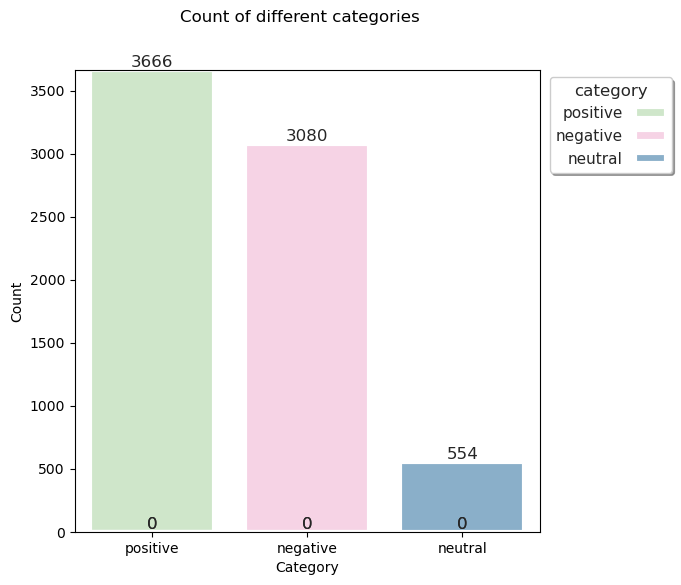

In [8]:
# Visualise the value counts in "category"
category_counts = climate_change_sentiment["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of different sentimental categories from 2")

sns.set_theme(style="whitegrid")

ranks = climate_change_sentiment["category"].sort_values().index

palette = sns.color_palette("Set3", len(ranks))

sns.countplot(ax=axes, data=climate_change_sentiment, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts))

plt.show()